<a href="https://colab.research.google.com/github/janpeter19/BPL_CHO_Fedbatch/blob/main/BPL_CHO_Fedbatch_fmpy_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BPL_CHO_Fedbatch script with FMPy

The key library FMPy is installed.

After the installation a small application BPL_CHO_Fedbatch is loaded and run. You can continue with this example if you like.

In [1]:
!lsb_release -a # Actual VM Ubuntu version used by Google

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.4 LTS
Release:	22.04
Codename:	jammy


In [2]:
!python --version

Python 3.12.12


In [3]:
!uv pip install fmpy

Using Python 3.12.12 environment at: /usr
Resolved 19 packages in 1.01s
Prepared 3 packages in 3.60s
Uninstalled 2 packages in 354ms
Installed 3 packages in 255ms
 - cmake==3.31.6
 + cmake==4.1.2
 + fmpy==0.3.26
 - numpy==2.0.2
 + numpy==2.3.4


# BPL_CHO_Fedbatch setup


Now specific installation and the run simulations. Start with connecting to Github. Then upload the two files:

* FMU - BPL_CHO_Fedbatch_linux_om_me.fmu
* Setup-file - BPL_CHO_Fedbatch_fmpy_explore

In [4]:
# Filter out DepracationWarnings for 'np.float as alias' is needed - wish I could make filter more narrow
import warnings
warnings.filterwarnings("ignore")

In [5]:
%%bash
git clone https://github.com/janpeter19/BPL_CHO_Fedbatch

Cloning into 'BPL_CHO_Fedbatch'...


In [6]:
%cd BPL_CHO_Fedbatch

/content/BPL_CHO_Fedbatch


# BPL_CHO_Fedbatch - demo
Author: Jan Peter Axelsson

This notebook deals with CHO fedbatch cultivation and recombinant protein production is included. First we make a check of the model by comparing a simulation result with the corresponding published diagram. We take a look at viable and dead cells and introduce cell lysis and negative effects on viable cell growth. Then we take a closer look at the start-up strategy to keep the by-product formation low. After that we investigate a whole cultivation and see the impact of feeding strategy on both cell growth and protein production where a trade-off is needed in this case.

The model used takes its inspiration from the microbial bottleneck models as described in the original papers [1] and [2] and reformulated and studied in [3]. The laboratory cultures used for model validation in [1] did produce mAb (against part of IgG) but no mAb-data was presented. The paper focus on viable and non-viable cell concentrations only. The original model is expanded with a state for lysed cells coming from dead cells [5, 7]. Further the lysed cell material is described as having a toxic negative effect on viable cell growth rate [5]. The character of this lysed cell material is further described in [6]. The original model is in section 6 further expanded with the classical empirical Luedeking-Piret model recombinant protein production, see chapter 5 in [7]. In this way can get more insight into choice of feeding profile.

The dead cell measurements presented in [1] is difficult and prone to errors, personal communication [6].

Interaction with the compiled model as FMU is mainly through the simplified commands: par(), init(), newplot(), simu() etc. The last simulation is always available in the workspace and called 'sim_res'. The command describe() brings mainly up description infomration from the actual Modelica code from the FMU but is complemented with information given in the dedicated Python setup-file.

The idea here is to demonstrate how simulations and varyiing conditions can provide some process insight that can support the experimental work. I hope that at the end of this session you are ready to formulate your own questions you want to address with simulations - and you can just go on in this notebook! Just press the field "+Code" in the upper left part of notebook interface and you get a new "cell" where you write your own code. You can copy and paste from cells above using ctrl-c and ctrl-v as usual and edit the cell. When your are ready to execute the cell just press the "play button" to the left in the cell or press shift-enter as in "ordinary" Jupyter notebooks.

After a session you may want to save your own notebook. That you can do on your Google Drive account and I refer to Colab instructions for how to do this. It is easy.

Good luck!

In [7]:
run -i BPL_CHO_Fedbatch_fmpy_explore.py

Linux - run FMU pre-compiled OpenModelica

Model for the process has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values/units

Note that both disp() and describe() takes values from the last simulation
and the command process_diagram() brings up the main configuration

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [8]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [25/2.54, 20/2.54]

## 1 About the process model

We can get information about the process and liquid phase by the command describe(). Here is no gas-phase included. This command can also be used to bring up information about a specific variable or parameter. However, you should use describe() after a simulation to get the valued used during the simulation.

No processDiagram.png file in the FMU, but try the file on disk.


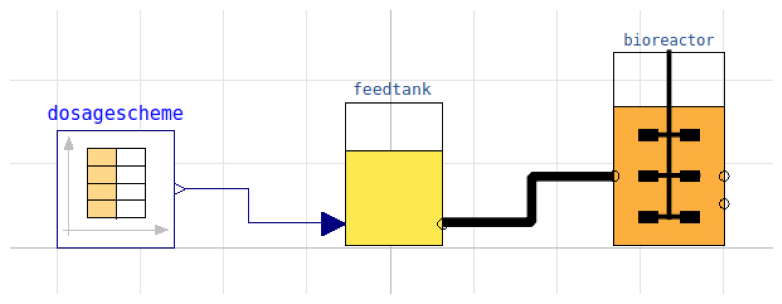

In [9]:
process_diagram()

In [10]:
describe('culture'); print(); #describe('liquidphase')                                  # Pump schedule parameter


Reactor culture CHO-MAb - cell line HB-58 American Culture Collection ATCC



The molecular weight of the recombinant protein (MAb) is somewhat arbitrarly chosen and the value not used in the simulations.

## 2 Simulation reproducing the original paper

The simulation below reproduce diagrams in Figure 5 in the original paper. There are several simulation in the paper showing how well the model describe different experiments and here I just choose one of them.

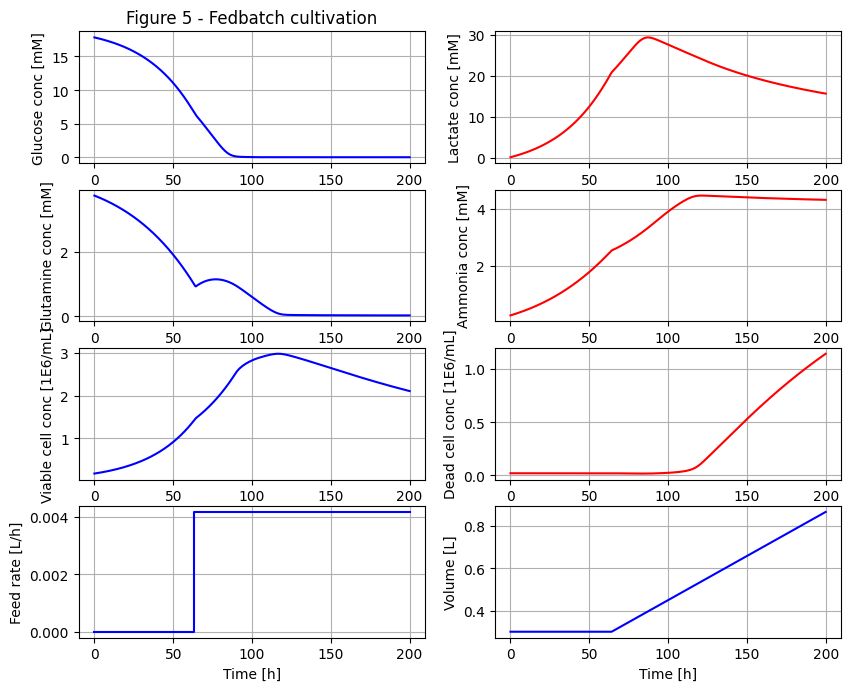

In [11]:
# Data from Table 1 and 2 for experiment 4 shown in Figure 5 in paper [1]
# -culture parameters taken from Table 5 identified parameters for cultures 1,2,and 3

# Initial process conditions
V_start=0.30
init(V_start=V_start, VXv_start=V_start*0.172, VXd_start=V_start*0.020)
init(VG_start=V_start*17.83, VGn_start=V_start*3.74, VL_start=V_start*0.12, VN_start=V_start*0.24)

# Feeding
Feed=0.1/24
par(G_in=15, Gn_in=9.3)
par(t0=0, F0=0, t1=63.5, F1=Feed, t2=300, F2=Feed)

# Simulation
newplot(title='Figure 5 - Fedbatch cultivation')
simu(200)

**Comment:** The simulation results looks very similar to the published diagram Figure 5 in [1]. The model pass this quality check.

## 3 Extending the model with cell lysis
A common experience in fedbatch cultivation of CHO is a slow decrease of viable cell number after the peak concentration is reached. This can be described in terms of accumulation of various toxic material during cultivation [5] and further characterized in [6].

The orginal model [1] does include cell death but not that dead cell concentration has any effect on the culture. The decrease in the viable cell concentration Xv in the previous simulation is actually just an effect of an increased volume of the reactor broth, i.e. a dilution effect. By instead plotting viable cell number VXv instead of Xv this fact is obvious.

The model can easily be extended by including a state for lysed cells VXl that is a variable that reflect the dead cells that have degraded into molecules. This lysis process is briefly outlined on page 195 in [7] and further discussed in [5, 6]. A measure Xl is released of cellular content like DNA or some enzyme like LDH [5].

Important is that the lysed material Xl has a negative effect of viable cell growth and here modelled as an increase in cell death rate. Here just added as a linear term k_toxix*Xl added to the original function of mu_d(G, Gn). The Xl may have a toxic effect also on recombinant protein production but not further studied here.

Here we take a look att the impact of typical values of lysis and toxicity on the original simulation above.

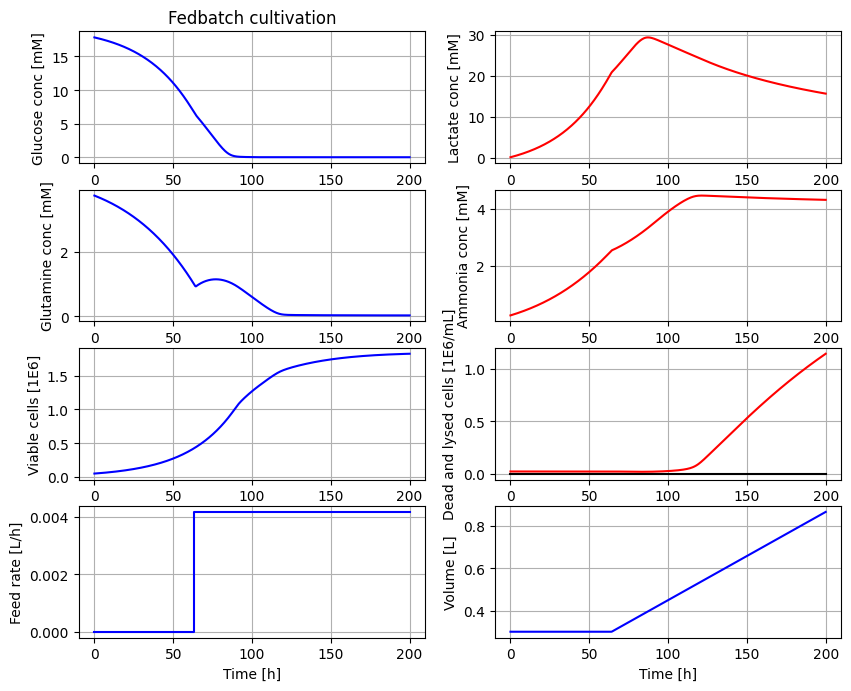

In [12]:
newplot(plotType='TimeSeries2')
show()

**Comment** Note Viable cell number VXv reach a plateu, i.e. does not decrease.

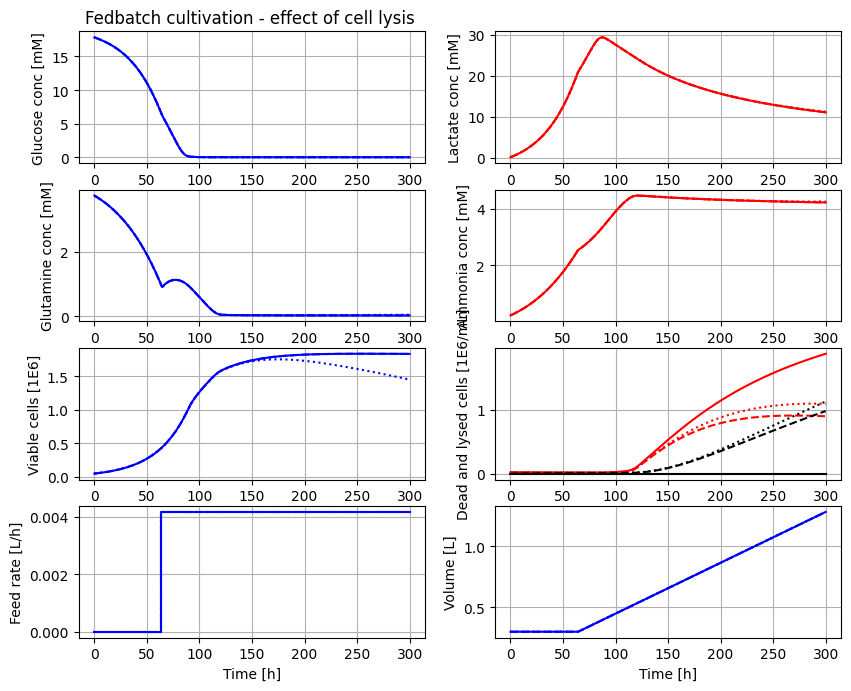

In [13]:
# Simulation
newplot(title='Fedbatch cultivation - effect of cell lysis ', plotType='TimeSeries2')

for value in [0, 0.01]:
   par(k_lysis_d=value, k_toxic=0)
   simu(300)

par(k_lysis_d=0.01, k_toxic=0.007)
simu(300)

# Restore default values
par(k_lysis_d=0, k_toxic=0)

**Comment** Note that just including lysis only decrease the number of dead cells (dashed line). If we also include the toxic effect of the lysed material then we get a decrease in viable cell number (dotted line). To illustarate the effect simulations are run 300 hours and a typical length for industrial recombinant protein production. A decrease of viable cell number with about 20 percent during the last part of the cultivation is rather typical.

## 4 Simulation of different start-up feeding strategies

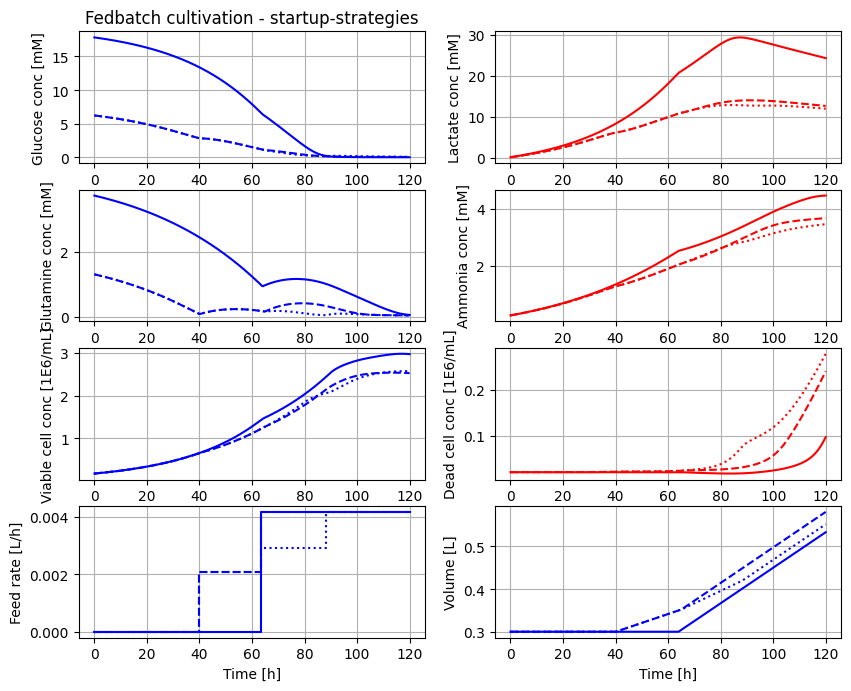

In [14]:
# Figur 5
V_0=0.30
init(V_start=V_start, VXv_start=V_start*0.172, VXd_start=V_start*0.020)
init(VG_start=V_start*17.83, VGn_start=V_start*3.74, VL_start=V_start*0.12, VN_start=V_start*0.24)

# Feeding
Feed=0.1/24
par(G_in=15, Gn_in=9.3)
par(t0=0, F0=0, t1=63.5, F1=Feed, t2=300, F2=Feed)

newplot(title='Fedbatch cultivation - startup-strategies')
simu(120)

init(VG_start=0.35*V_start*17.83, VGn_start=0.35*V_start*3.74)
par(t0=0, F0=0, t1=40.0, F1=0.5*Feed, t2=63.5, F2=Feed,t3=300, F3=Feed)
simu(120)

init(VG_start=0.35*V_start*17.83, VGn_start=0.35*V_start*3.74)
par(t0=0, F0=0, t1=40.0, F1=0.5*Feed, t2=63.5, F2=0.7*Feed, t3=88.0, F3=Feed, t4=300, F4=Feed)
simu(120)

# Reset time table to avoid problems below
par(t1=1001, t2=1002, t3=1003, t4=1004, t5=1005, t6=1006)

**Comment:** We see that starting the feed a day erlier at lower rate and then increase decreaes lactate formation to half, while the cell conentation is just slightlly lower. With a more careful design of the feedprofile the ammonia formation can be decreased more than shown here.

## 5 Simulation of optimal feed profile for cell growth

At the end of the original paper section 5 in [1], the derived model is used to find an optimal feeding profile for high final cell concentration. It is stated that protein productivity is assumed to be mainly positively growth associated and therefore optimization of cell concentration is very similar to optimization of protein product. The optimization of feed profile is done with differnt structures of the feed profile. All of them have a start-time and all of them has a fixed amount of substrate and concentrations in the media are also the same.

* The first optimzation is for a feed profile similar to the experimental, i.e. after start the feed rate remains constant throughout the cultivation. Thus the start time and the actual feed rate are optimized. The result was that the start time was about the same as expermentally but the feed rate was 50% higher, see Figure 7 and Figure 10 in [1].

* The second optimization is for a feed profile with not just one increase but three steps of increase of feed rate. The results is a somwehat higher final cell concentration, see Figure 11.

* The third optimization is for a feed profile with five steps of increase of feed rate. The results is a slightly higher final cell concentration than for three steps, see Figure 12.

* The fourth optimization is for a feed profie with continuous exponential increase of the reed rate. The result is a bit higher final concentration than the previous with five steps, see Figure 13 but not shown in the figure below.

Below we just show the results of the original experimetnal cultivation, compared with results from three and five steps.
It is possible to do the optimization in Python with the FMU, but we save that for a future notebook.

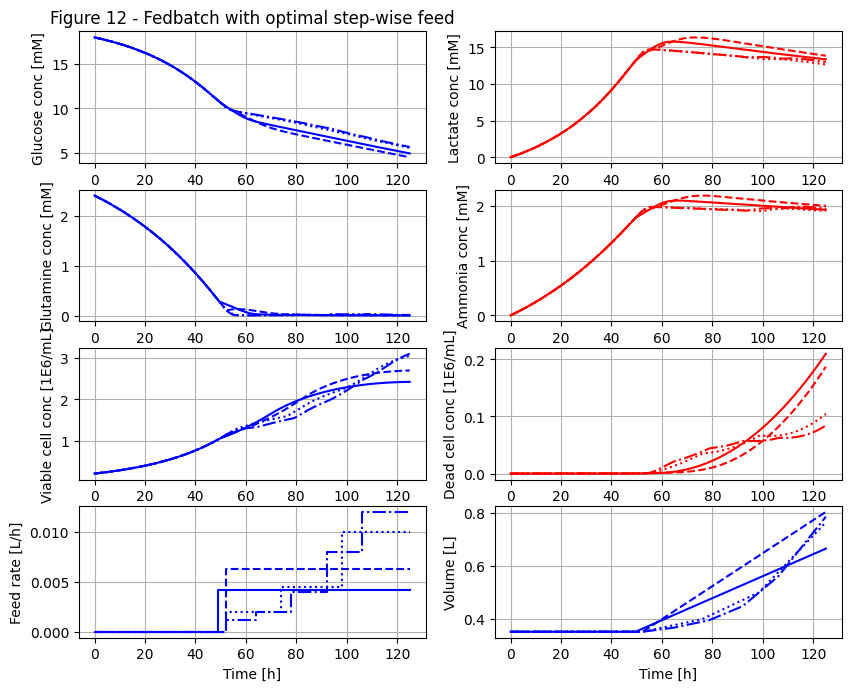

In [15]:
# Culture parameters taken from Table 5 identified parameters for cultures 1,2,and 3

# Data chosen
V_start=0.35
init(V_start=V_start, VXv_start=V_start*0.20, VXd_start=V_start*0.0)
init(VG_start=V_start*18.0, VGn_start=V_start*2.4, VL_start=V_start*0, VN_start=V_start*0)

# Feeding n=1 - experimental and lower feed rate
par(G_in=15, Gn_in=4.0)
par(t0=0, F0=0, t1=49, F1=0.00417)
par(t2=1002, t3=1003, t4=1004, t5=1005)

# Simulation
newplot(title='Figure 12 - Fedbatch with optimal step-wise feed')
simu(125)

# Feeding n=1
par(G_in=15, Gn_in=4.0)
par(t0=0, F0=0, t1=52, F1=0.00625)
par(t2=1002, t3=1003, t4=1004, t5=1005, t6=1006)

# Simulation
simu(125)

# Feeding n=3
par(G_in=15, Gn_in=4.0)
par(t0=0, F0=0, t1=52, F1=0.002, t2=74, F2=0.0045, t3=98.0, F3=0.010)
par(t4=99.0, F4=0.010, t5=106, F5=0.010, t6=150, F6=0.010)

# Simulation
simu(125)

# Feeding n=5
par(G_in=15, Gn_in=4.0)
par(t0=0, F0=0, t1=52, F1=0.0012, t2=64, F2=0.0020, t3=78.0, F3=0.0040)
par(t4=92.0, F4=0.0080, t5=106, F5=0.012, t6=150, F6=0.012)

# Simulation
simu(125)

# Reset feeding parameters since the table need time in strict increasing value
par(t3=1004, t4=1005, t5=1005, t6=1006)

**Comment:** We see that that already the better tuned constant feed rate (dahsed) compared to the experimental (solid) gives higher final cell concnetration.

Breaking up the constant feed rate in three (dotted) and five (dash-dotted) steps with a more gradual increase of the feed rate gives even higher final cell concentration. The difference between n=3 and n=5 is small. The change to continuous exponential feed is even smaller and not shown here.

The results shown here are similar to what is presented in Table 7 in [1] but our simulation are slightly longer and here are small differences in the final cel concentration too. The qualitative result is the same though. The difference we see to the result in the original paper is most likely due to the fact that we here use the full model with 17 parameters while in the paper they have reduced the model to 15 parameters for the optimization work.

## 6 Simulation of different feed profiles to increase recombinant protein production

In this section we take a closer look at recombinant protein production. The original model is extended with the empirical model for specific protein production, see chapter 5 in [4]

$$
q_P = \alpha \cdot \mu + \beta
$$

Here we choose a negative value of growth-associated protein production production $\alpha$ while keeping the non-growth associated $\beta$ positive. The culture produced recombinant protein in the form of monoclonal antibodies for a specific IgG1 molecule,see section 2 in [1]. However, no experimental results were given. The only information we have is that feed rate was kept constant at a low level during fedbatch production and this choice indicates that the the growth-associated protein production is negative. The consequence of this observation for the feed profile we take a look at there by simulation.

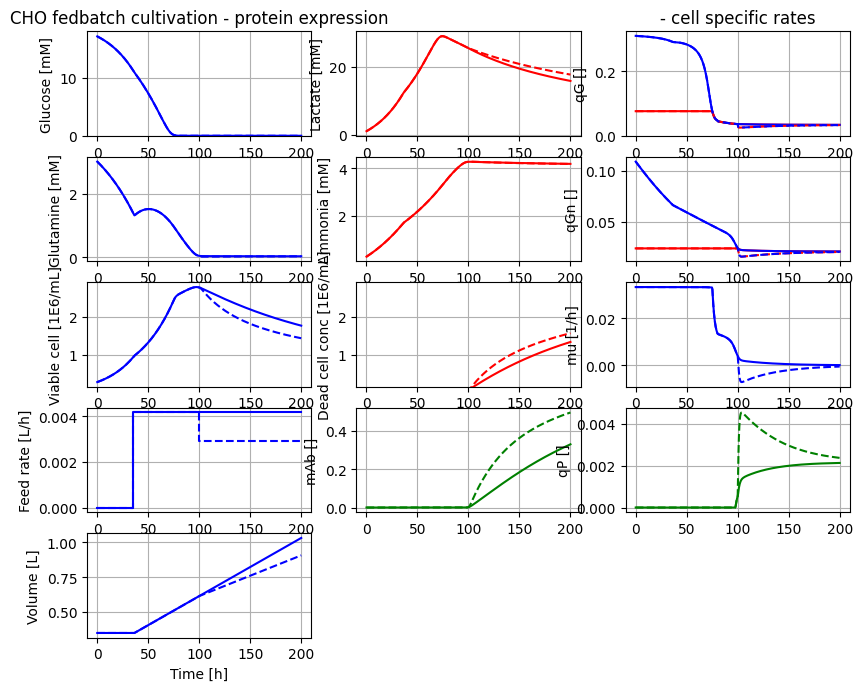

In [16]:
# Slide 3
newplot('CHO fedbatch cultivation - protein expression', plotType='Textbook_3')

# Data from Table 1 and 2 for experiment 3
V_start=0.35
init(V_start=V_start, VXv_start=V_start*0.29, VXd_start=V_start*0.010)
init(VG_start=V_start*17.17, VGn_start=V_start*3.02, VL_start=V_start*1.12, VN_start=V_start*0.29)

# Feeding
Feed=0.1/24
par(G_in=15, Gn_in=9.3)
par(t0=0, F0=0, t1=35, F1=Feed, t2=100, F2=Feed, t3=300, F3=Feed)

# Culture parameters
par(alpha=-1.0, beta=0.01)

# Simulation
simu(200)
par(t2=100, F2=0.7*Feed, t3=300, F3=0.7*Feed); simu(200)
par(F2=Feed, F3=Feed)

**Comment:** The simulation results show that actually a decease in the feed rate can lead to an increase in recombinant protein produced, although the cell concentration is a bit lower. This is a result due to the fact that growth-associated protein production here is set to a negative value. The main point is that the model can actually capture this phenomena.

## 7 Summary
In short we have done the following:

* Section 2: The model was checked by comparing the simulation results with one of the published diagrams [1].

* Section 3: The original model was extended with a state for lysed cells and also included with modelling the toxicity of lysed cells increasing the cell death rate [5]. With typical values we could model a typical decrease in viable cell count during the later part of the cultivation.

* Section 4: The common startup-procedure with 3 days batch cultivation can be questioned. We found that by shorten it to 2 days, and giving smaller feed rate day 3, byproduct formation can be kept lower at the prize of just a bit lower cell concentration. Similar idea was shown in section 2.1 in [3].

* Section 5: In the original paper the experimental feeding strategy was to keep the substrate feed at a constant lower level. The authors made a point of that the optimal feeding strategy should be exponential for maximal cell production. This is an insight derived from the bottle-neck model and they showed that through simulation optimization [1]. However, there was no experimental support to confirm the results. The optimal cell growth feedprofile simulation was just reproduced here.

* Section 6: The model was further extended to include recombinant protein production. Here we do that with the empirical model that distinguish between growth-associated and non-growth-associated protein production, see chapter 5 in [7]. Now we can study optimization of recombinant protein production. For a class of CHO-processes the recombinant protein productivity is acutally negatively affected by cell growth. Simulation of the original model extended with such a protein production model shows that keeping the substrate feed rate constant as the cell culture grows, giving less and less feed per cell, actually can give higher protein production than an increaeing feed rate. Simulation confirms this idea. The results gives some possible background to why the constant feed rate was used experimetnally in the original paper [1].

## 8 References
[1] Amribt, Z., Niu, H. and Bogaerts P.: "Macroscopic modelling of overflow metabolism and model based optimization of hybridoma cell fed-batch cultures.", Biochem. Eng. Journal, 2013.

[2] Niu,H., Amribt, Z., Fickers, P., Tan, W. and Bogaerts P.: "Metabolic pathway analysis and reduction for mammalian cell cultures - towards macroscopic modelling", Chem. Eng. Science, 2013.

[3] Axelsson, J. P.: "Simplified model of CHO-cultivation in Bioproces Library for Modelica - some experience", conference paper 22nd NPCW Lyngby, Denmark, August 22-23, 2019.

[4] Bogaerts, P.: "Stated that dead cell measurements in Amribts work most likely had larger errors, and later work and publications with the same data sets omitted these dead cell data", met at DYCOPS-CAB in Trondheim, Norway, in june 2016.

[5] Kroll, P., Eilers, K., Fricke, J and Herwig C.: "Impact of cell lysis on the description of cell growth and death in cell culture", Eng. in Life Sci, 2017.

[6] Mulukutla, B. C., Kale, J.,  Kalomeris, T., Jaccobs, M., Hiller, G. W.: "Identification and control of novel growth inhibitors in fed-batch cultivation of Chinese hamster ovary cells.", Biotech. Bioeng., 2017.

[7] Hu, W-S: "Cell culture bioprocess engineering", 2nd edition, CRC Press, 2020.

## Appendix

In [17]:
# List of components in the process setup and also a couple of other things like liquidphase and gasphase etc
describe('parts')

['bioreactor', 'bioreactor.broth_decay', 'bioreactor.culture', 'dosagescheme', 'feedtank']


In [18]:
describe('MSL')

MSL: 4.1.0 - used components: RealInput, RealOutput, CombiTimeTable, Types


In [19]:
system_info()


System information
 -OS: Linux
 -Python: 3.12.12
 -Scipy: not installed in the notebook
 -FMPy: 0.3.26
 -FMU by: OpenModelica Compiler OpenModelica 1.26.0~dev-200-gcb3254b
 -FMI: 2.0
 -Type: ME
 -Name: Fedbatch
 -Generated: 2025-07-23T10:13:29Z
 -MSL: 4.1.0
 -Description: Bioprocess Library version 2.3.1
 -Interaction: FMU-explore for FMPy version 1.0.2
